Example of training fastText model and getting sentence embeddings

In [18]:
from gensim.models import FastText
from scipy import spatial


def get_sentence_embedding(model, sentence):
  # This method takes in the trained model and the input sentence
  # and returns the embedding of the sentence as the average embedding
  # of its words
  words = sentence.split(" ")
  vector = model.wv[words[0]]
  for i in range(1, len(words)):
    vector = vector + model.wv[words[i]]
  return vector/len(words)

In [19]:
import re

# Removes HTML tags
def remove_tags(string):
    return re.sub("<[^>]*>", "", string)

Reading Law Stack Exchange Data

In [20]:
import csv

def read_tsv_test_data(file_path):
  # Takes in the file path for test file and generate a dictionary
  # of question id as the key and the list of question ids similar to it
  # as value. It also returns the list of all question ids that have
  # at least one similar question
  dic_similar_questions = {}
  lst_all_test = []
  with open(file_path) as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        question_id = int(row[0])
        lst_similar = list(map(int, row[1:]))
        dic_similar_questions[question_id] = lst_similar
        lst_all_test.append(question_id)
        lst_all_test.extend(lst_similar)
  return dic_similar_questions, lst_all_test

In [21]:
from gensim.models import FastText
import os


# Function that FastText trains model. 
# If file name of model exist, uses that model.
# Else creates new model and saves to file_name
def train_model(lst_sentences, file_name):

  if (os.path.exists(file_name)):
    model = FastText.load(file_name)
  else:
    model = FastText(window = 5, min_n=1)
    model.build_vocab(lst_sentences)
    model.train(lst_sentences, total_examples=len(lst_sentences), epochs=30)  # train

    # saving the model in-case you need to reuse it
    model.save(file_name)

  return model

In [22]:
# Functions for getting embeddings

def get_dic_question_embedding_title(model, reader):
    dic_question_embedding = {}
    for question_id in reader.map_questions:
        title = reader.map_questions[question_id].title
        dic_question_embedding[question_id] = get_sentence_embedding(model, remove_tags(title))
    return dic_question_embedding

def get_dic_question_embedding_body(model, reader):
    dic_question_embedding = {}
    for question_id in reader.map_questions:
        body = reader.map_questions[question_id].body
        dic_question_embedding[question_id] = get_sentence_embedding(model, remove_tags(body))
    return dic_question_embedding

def get_dic_question_embedding_title_and_body(model, reader):
    dic_question_embedding = {}
    for question_id in reader.map_questions:
        title = reader.map_questions[question_id].title
        body = reader.map_questions[question_id].body
        dic_question_embedding[question_id] = get_sentence_embedding(model, remove_tags(title + body))
    return dic_question_embedding

In [23]:

# Gets the embedding results of finding similar question to the list of questions
def get_embedding_results (dic_question_embedding, dic_similar_questions, reader, prt_type):
    dictionary_result = {}

    # Test if test question find correct similar question through cosine similarility
    for test_question_id in dic_similar_questions:

        vector_test = dic_question_embedding[test_question_id]
        maxCosine = -1
        question_id_highest_cosine = ""

        for question_id in reader.map_questions:
            if question_id == test_question_id:
                continue

            vector_question = dic_question_embedding[question_id]
            result = 1 - spatial.distance.cosine(vector_question, vector_test)
            if result > maxCosine:
                maxCosine = result
                question_id_highest_cosine = question_id

        dictionary_result[test_question_id] = question_id_highest_cosine

    # Calculate P@1
    yeses = 0
    count = 0
    for question_id in dictionary_result:

        for question_real in dic_similar_questions[question_id]:
            if dictionary_result[question_id] == question_real:
                yeses = yeses + 1
        count = count + 1

    # Print data information
    print("Correct " + prt_type + ": " + str(yeses))
    print("Count " + prt_type + ": " + str(count))
    print("Average P@1 " + prt_type + ": " + str(yeses / count))
    return dictionary_result

In [24]:
from post_parser_record import PostParserRecord

def main():
  duplicate_file = "duplicate_questions.tsv"
  post_file = "Posts_law.xml"
  dic_similar_questions, lst_all_test = read_tsv_test_data(duplicate_file)
  post_reader = PostParserRecord(post_file)
  lst_training_sentences_titles = []
  lst_training_sentences_body = []
  for question_id in post_reader.map_questions:
    if question_id in lst_all_test:
      continue
    question = post_reader.map_questions[question_id]
    title = question.title
    body = question.body
    # Collect sentences here
    lst_training_sentences_titles.append(remove_tags(title))
    lst_training_sentences_body.append(remove_tags(body))

    lst_answers = question.answers
    if lst_answers is not None:
      for answer in lst_answers:
        answer_body = answer.body
        # Collection sentences here
        # Your code

  # Training and results of title + body
  model = train_model(lst_training_sentences_titles + lst_training_sentences_body, "owenTest.model")
  dic_question_embedding = get_dic_question_embedding_title_and_body(model, post_reader)

  dictionary_result = get_embedding_results (dic_question_embedding, dic_similar_questions, post_reader, "title + body")

  # Training and results of body
  model = train_model(lst_training_sentences_body, "owenTest_body.model")
  dic_question_embedding = get_dic_question_embedding_body(model, post_reader)

  dictionary_result = get_embedding_results (dic_question_embedding, dic_similar_questions, post_reader, "body")

  # Training and results of title
  model = train_model(lst_training_sentences_titles, "owenTest_title.model")
  dic_question_embedding = get_dic_question_embedding_title(model, post_reader)

  dictionary_result = get_embedding_results (dic_question_embedding, dic_similar_questions, post_reader, "title")


main()

Correct title + body: 4
Count title + body: 282
Average P@1 title + body: 0.014184397163120567
Correct body: 7
Count body: 282
Average P@1 body: 0.024822695035460994
Correct title: 12
Count title: 282
Average P@1 title: 0.0425531914893617


Feedforward Neural Network

In [6]:
import torch
import torch.nn as nn

class FeedForwardNeuralNetwork(nn.Module):
  def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
    super(FeedForwardNeuralNetwork, self).__init__()

    self.layer_1 = nn.Linear(input_dim, hidden_dim_1)
    self.relu_1 = nn.Tanh()

    self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
    self.relu_2 = nn.Tanh()
    
    self.layer_3 = nn.Linear(hidden_dim_2, output_dim)

  def forward(self, x):
    out = self.layer_1(x)
    out = self.relu_1(out)

    out = self.layer_2(out)
    out = self.relu_2(out)
    
    out = self.layer_3(out)
    return torch.sigmoid(out)



In [7]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

class myModel():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = 100 # Two questions
    hidden_dim_1 = 128
    hidden_dim_2 = 64
    out_dim = 1 # Binary classification

    model = FeedForwardNeuralNetwork(input_dim, hidden_dim_1, hidden_dim_2, out_dim)

    # loss function
    criterion = nn.CrossEntropyLoss()

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # moving to GPU if available
    model.to(device)
    criterion = criterion.to(device)

    def calculate_accuracy(self, y_true, y_pred):
        y_pred = torch.round(y_pred)
        correct = (y_true == y_pred).float()
        acc = correct.sum() / len(correct)
        return acc

    def training(self, tfidfX_train, Y_train, tfidfX_val, Y_val, num_epochs):
        batch_size = 200
        X_train_mini_batches = torch.split(tfidfX_train, batch_size)
        Y_train_mini_batches = torch.split(Y_train, batch_size)

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        best_accuracy = 0

        for epoch in range(num_epochs):
            epoch_loss = 0
            epoch_accuracy = 0
            validation_loss = 0
            val_accuracy = 0
            for X_train_mini_batch, Y_train_mini_batch in zip(X_train_mini_batches, Y_train_mini_batches):
                X_train_mini_batch = X_train_mini_batch.to(self.device)
                Y_train_mini_batch = Y_train_mini_batch.to(self.device)

                # forward pass
                train_prediction = self.model.forward(X_train_mini_batch.float())

                # returns a tensor with all the dimensions of input of size 1 removed
                train_prediction = torch.squeeze(train_prediction)

                # calculate loss
                train_loss = self.criterion(train_prediction, Y_train_mini_batch)

                # clearing up acculated gradients
                self.optimizer.zero_grad()

                # getting gradients
                train_loss.backward()

                # updating parameters
                self.optimizer.step()

                # add each mini batch's loss
                epoch_loss += train_loss.item()

                # add each mini batch's accuracy
                epoch_accuracy += self.calculate_accuracy(Y_train_mini_batch, train_prediction)

            tfidfX_val = tfidfX_val.to(self.device)
            Y_val = Y_val.to(self.device)

            # Forward pass to get output
            val_prediction = self.model.forward(tfidfX_val.float())
            val_prediction = torch.squeeze(val_prediction)

            # Calculate Loss
            val_loss = self.criterion(val_prediction, Y_val)
            # print(val_loss)
            # Add each mini batch's loss
            validation_loss = val_loss.item()

            # Add each mini batch's accuracy
            val_accuracy = self.calculate_accuracy(Y_val, val_prediction)
            if val_accuracy > best_accuracy:
                torch.save(self.model.state_dict(), 'best_model_state.bin')
                best_accuracy = val_accuracy
            # for generating train/validation loss plot
            epoch_loss /= len(X_train_mini_batches)
            epoch_accuracy /= len(X_train_mini_batches)
            val_losses.append(validation_loss)
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)
            val_accuracies.append(val_accuracy)
        plt.figure(figsize=(10, 8))
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.title('First Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

    def __loadModel(self, ):
        self.model.load_state_dict(torch.load('best_model_state.bin'))

    def test(self, tfidfX_test, Y_test):
        self.__loadModel()
        tfidfX_test = tfidfX_test.to(self.device)
        Y_test = Y_test.to(self.device)
        # forward pass to get output
        test_prediction = self.model.forward(tfidfX_test.float())
        test_prediction = torch.squeeze(test_prediction)

        # calculate accuracy
        test_accuracy = self.calculate_accuracy(Y_test, test_prediction)

        print(Y_test)
        print(test_prediction)
        print("Test Accuracy:", round(test_accuracy.item(), 4), "\n")

training begins


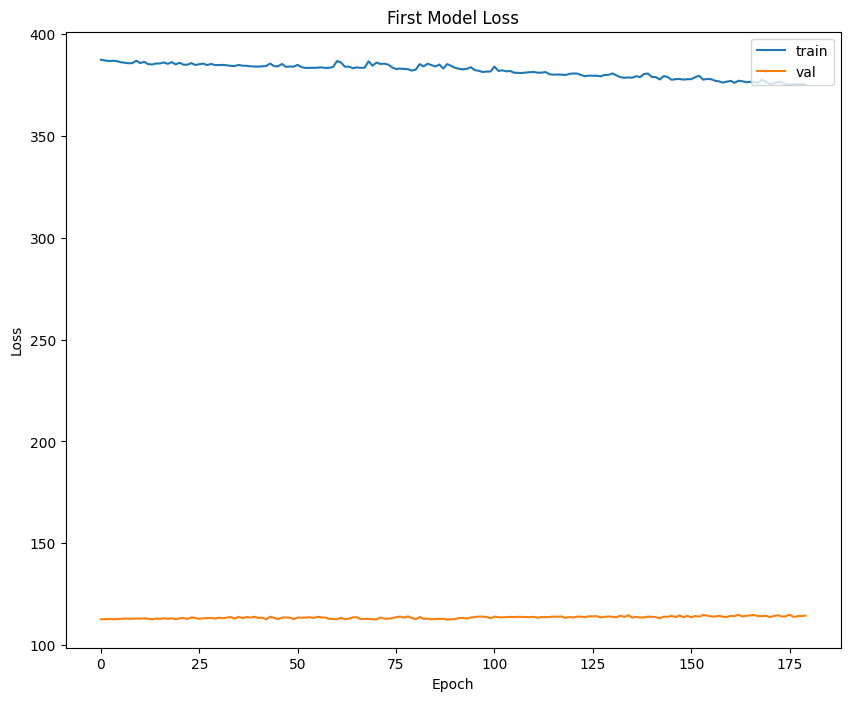

tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0.])
tensor([0.7261, 0.0428, 0.8522, 0.7698, 0.8823, 0.9114, 0.0173, 0.2378, 0.3140,
        0.0342, 0.0636, 0.4182, 0.7949, 0.7283, 0.7695, 0.8105, 0.7324, 0.8868,
        0.1190, 0.6181, 0.7480, 0.5275, 0.6687, 0.1894, 0.4706, 0.3508, 0.9599,
        0.8505, 0.7083, 0.8139, 0.9107, 0.4084, 0.6523, 0.7252, 0.3121, 0.2365,
        0.7037, 0.1359, 0.8365, 0.1994, 0.0818, 0.7091, 0.6377, 0.8754, 0.5756,
        0.7867, 0.0753, 0.1866, 0.9199, 0.8578, 0.8257, 0.0779, 0.8335, 0.6318,
        0.8876, 0.8244], grad_fn=<SqueezeBackward0>)
Test Accuracy: 0.5714 



In [8]:
import numpy as np
import random
from post_parser_record import PostParserRecord

modelFeedForward = myModel()
training_x = []
training_y = []
test_x = []
test_y = []
val_x = []
val_y = []
count = 0

duplicate_file = "duplicate_questions.tsv"
post_file = "Posts_law.xml"
dic_similar_questions, lst_all_test = read_tsv_test_data(duplicate_file)
post_reader = PostParserRecord(post_file)
lst_training_sentences_titles = []
lst_training_sentences_body = []

# train your model
model = train_model(lst_training_sentences_titles + lst_training_sentences_body, "owenTest.model")
# This dictionary will have the test question id as the key
# and the most similar question id as the value
dictionary_result = {}

# finding Similar questions using fastText model
for test_question_id in dic_similar_questions:
    
    # for this question you have to find the similar questions
    test_question = post_reader.map_questions[test_question_id]
    test_title = test_question.title
    test_body = test_question.body

    test_duplicate = post_reader.map_questions[dic_similar_questions[test_question_id][0]]
    test_title_dup = test_duplicate.title
    test_body_dup = test_duplicate.body

    vector = get_sentence_embedding(model, remove_tags(test_title + test_body)) + get_sentence_embedding(model, remove_tags(test_title_dup + test_body_dup))
    # Getting 80% of the data for training
    if count < len(dic_similar_questions) * 0.8:
        training_x.append(vector)
        training_y.append(1)
        # Negative sampling by getting random question. Can grab multiple, but set to one for getting 50% negative sample
        for i in range(0, 1):
            index = random.randint(0, len(post_reader.map_questions) - 1)
            count_found = 0
            for question_id in post_reader.map_questions:
                if count_found == index:
                    question = post_reader.map_questions[question_id]
                    if question_id != test_question_id:
                        vector = get_sentence_embedding(model, remove_tags(test_title + test_body)) + get_sentence_embedding(model, remove_tags(question.title + question.body))
                        training_x.append(vector)
                        training_y.append(0)
                count_found = count_found + 1
    # Getting 10% of data for validation (between 80% and 90%)
    elif count < len(dic_similar_questions) * 0.9:
        val_x.append(vector)
        val_y.append(1)
        # Negative sampling by getting random question. Can grab multiple, but set to one for getting 50% negative sample
        for i in range(0, 1):
            index = random.randint(0, len(post_reader.map_questions) - 1)
            count_found = 0
            for question_id in post_reader.map_questions:
                if count_found == index:
                    question = post_reader.map_questions[question_id]
                    if question_id != test_question_id:
                        vector = get_sentence_embedding(model, remove_tags(test_title + test_body)) + get_sentence_embedding(model, remove_tags(question.title + question.body))
                        val_x.append(vector)
                        val_y.append(0)
                count_found = count_found + 1
    # Getting the last 10% of the data for testing
    else:
        test_x.append(vector)
        test_y.append(1)
        # Negative sampling by getting random question. Can grab multiple, but set to one for getting 50% negative sample
        for i in range(0, 1):
            index = random.randint(0, len(post_reader.map_questions) - 1)
            count_found = 0
            for question_id in post_reader.map_questions:
                if count_found == index:
                    question = post_reader.map_questions[question_id]
                    if question_id != test_question_id:
                        vector = get_sentence_embedding(model, remove_tags(test_title + test_body)) + get_sentence_embedding(model, remove_tags(question.title + question.body))
                        test_x.append(vector)
                        test_y.append(0)
                count_found = count_found + 1

    count = count + 1


# (Question 1, Question 2)
# 0 = not duplicate, 1 = duplicate
training_x = torch.from_numpy(np.asarray(training_x)).type(torch.FloatTensor)
training_y = torch.from_numpy(np.asarray(training_y)).type(torch.FloatTensor)
val_x = torch.from_numpy(np.asarray(val_x)).type(torch.FloatTensor)
val_y = torch.from_numpy(np.asarray(val_y)).type(torch.FloatTensor)
print("training begins")
modelFeedForward.training(training_x, training_y, val_x, val_y, 180)

test_x = torch.from_numpy(np.asarray(test_x)).type(torch.FloatTensor)
test_y = torch.from_numpy(np.asarray(test_y)).type(torch.FloatTensor)
modelFeedForward.test(test_x, test_y)